# <span style='font-family:Georgia'> Topic: Image generation with generative adversarial networks  

**Dataset**: sample of the [LSUN Bedrooms Dataset](https://www.kaggle.com/jhoward/lsun_bedroom)

**Requirements**:
- test and compare different network architectures (at least one of them should converge to generate satisfactory images)
- potential architectures (can use different ones): vanilla GAN with CNNs, DC-GAN, Wasserstein GAN, WGAN-GP, SN-GAN, StyleGAN1, StyleGAN2 (with or without data augmentations), StyleGAN3
- calculate the Frechet Inception Distance (FID) for your generated images and compare it to results from literature
- assess your results qualitatively
- investigate the influence of hyperparameters on obtained results
- discuss sets of hyperparameters which help in overcoming training collapse and mode collapse
- select two of your generated images together with their latent vectors; interpolate linearly between the two latent vectors to generate 8 additional latent vectors; use these 8 vectors to generate images from your model; present the 10 generated images (8 newly generated and 2 generated previously) and discuss the importance of the results
    

**Resources**:
- https://walkwithfastai.com/Super_Resolution
- https://medium.com/analytics-vidhya/understanding-fastai-v2-training-with-a-computer-vision-example-part-3-fastai-learner-and-a3ea85c6fe78
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


- https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-wgan.ipynb
- https://github.com/aarcosg/fastai-course-v3-notes/blob/master/refactored_by_topics/CNN_L7_gan_feature-loss.md


- https://github.com/wiseodd/generative-models
    
**Empty generator issue cause**:
- https://github.com/fastai/fastai_dev/issues/24

**Hyperparameters to be tuned:**
- `batch size`
- `lr` \& `wd`: the learning rate \& weight decay to be used by the optimizer

In [1]:
# conda create -n fastai python=3.7
# conda activate fastai
# conda install -c conda-forge jupyterlab
# conda install pytorch torchvision torchaudio -c pytorch
# pip install fastai
# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=fastai

In [2]:
import fastai
print(fastai.__version__)
from fastai.vision.gan import *
from fastai.vision.all import *
from fastai.vision.data import *
from tqdm.notebook import tqdm

2.6.3


## <span style='font-family:Georgia'> Approach 1. - WGAN

In [3]:
path = "../../data/test/data0/lsun/bedroom"  # TODO: zmiana elementu "test" w ścieżce na "sample"

In [4]:
# bs = 128
bs = 12
size = 64

In [5]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)],
                  n_inp=1)

In [6]:
dls = dblock.dataloaders(path, path=path, bs=bs)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


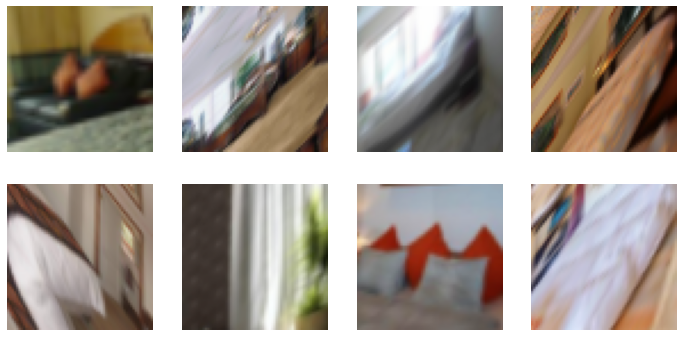

In [7]:
dls.c = 3
dls.show_batch(max_n=8)

In [8]:
generator = basic_generator(out_size=64, n_channels=3, n_extra_layers=1)
critic = gan_critic(n_channels=3)

In [9]:
learn = GANLearner.wgan(dls, generator, critic, switch_eval=False,
                        opt_func = partial(fastai.optimizer.Adam))

In [10]:
learn.fit_one_cycle(1, 1e-3)

C:\Users\ejowik001\Anaconda3\lib\site-packages\fastai\callback\core.py:67: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
C:\Users\ejowik001\Anaconda3\lib\site-packages\fastai\callback\core.py:67: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
C:\Users\ejowik001\Anaconda3\lib\site-packages\fastai\callback\core.py:67: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,-404.355011,None,None,None,33:32


C:\Users\ejowik001\Anaconda3\lib\site-packages\fastprogress\fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## <span style='font-family:Georgia'> Approach 2. - GAN

In [11]:
path_lr = '../../data/test/data0/lsun/small-96'  # TODO: zmiana elementu "test" w ścieżce na "sample"
path_hr = '../../data/test/data0/lsun/bedroom'  # TODO: zmiana elementu "test" w ścieżce na "sample"

In [12]:
from PIL import Image, ImageDraw, ImageFont

In [13]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [14]:
class Crappifier():
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [15]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [16]:
items = get_image_files(path_hr)

In [17]:
for item in tqdm(items):
    Crappifier(path_lr, path_hr).__call__(item)

  0%|          | 0/4937 [00:00<?, ?it/s]

In [18]:
bad_im = get_image_files(path_lr)

In [19]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

<AxesSubplot:>

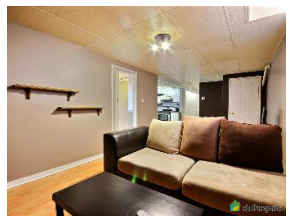

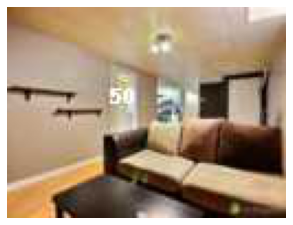

In [20]:
im1.show(); im2.show(figsize=(5,5))

In [21]:
dls_gen = get_dls(32, 128)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


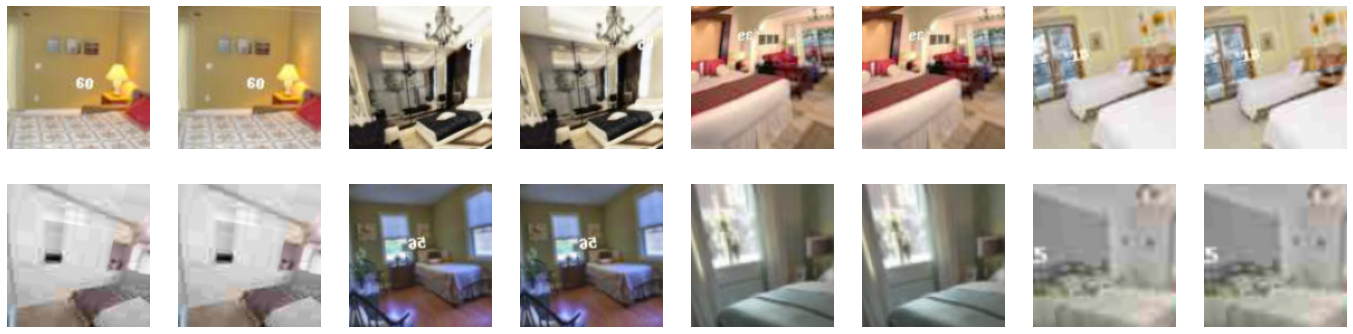

In [22]:
dls_gen.show_batch(max_n=8)

In [23]:
x,y = dls_gen.one_batch()

In [24]:
x.size()

torch.Size([32, 3, 128, 128])

In [25]:
y.size()

torch.Size([32, 3, 128, 128])

In [26]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [27]:
bbone = resnet34

In [28]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [29]:
learn_gen = create_gen_learner()

In [30]:
learn_gen.fit_one_cycle(1, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.066902,0.013947,37:02


In [31]:
learn_gen.unfreeze()

In [32]:
learn_gen.fit_one_cycle(1, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.005625,0.005226,35:55


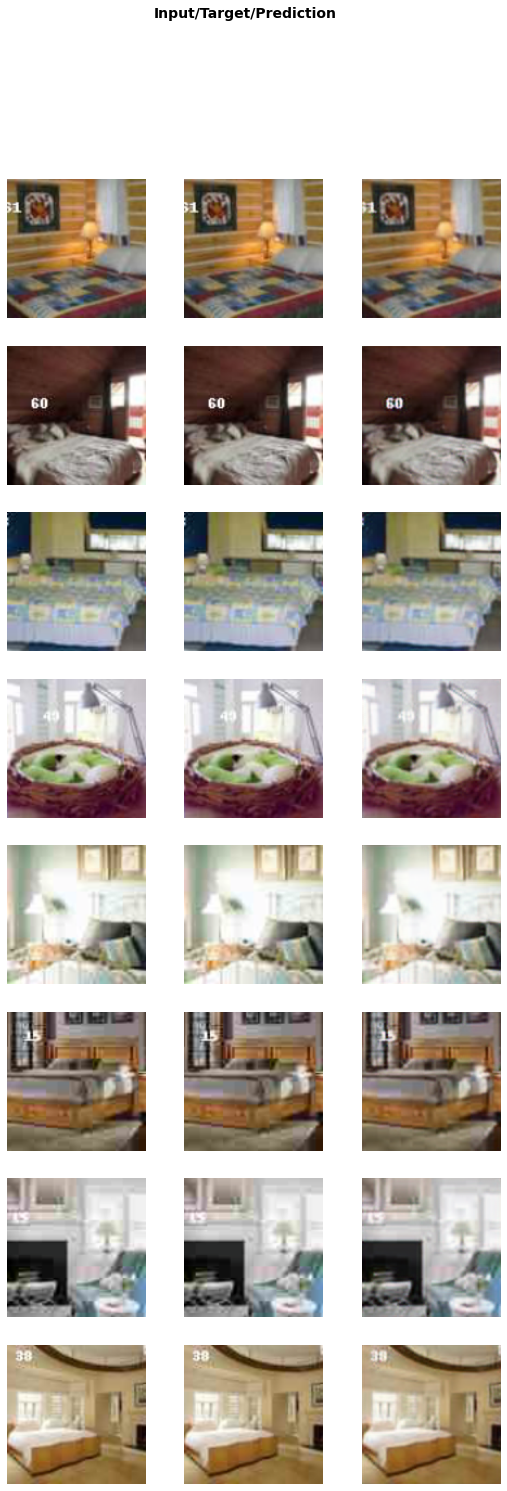

In [33]:
learn_gen.show_results(max_n=8)

In [34]:
learn_gen.save('gen-pre2')

Path('../../data/test/data0/lsun/bedroom/models/gen-pre2.pth')

In [35]:
# Save the generated images so they can be used them for critic model
name_gen = 'image_gen'
path_gen = Path(f'../../data/test/data0/lsun/{name_gen}')

In [36]:
path_gen.mkdir(exist_ok=True)

In [37]:
def save_preds(dl, learn):
    "Save away predictions"
    names = dl.dataset.items

    preds,_ = learn.get_preds(dl=dl)
    for i, pred in enumerate(preds):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(path_gen/names[i].name)

In [38]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [39]:
preds, _ = learn_gen.get_preds(dl=dl)

In [40]:
preds[0].shape

torch.Size([3, 128, 128])

In [41]:
preds[0][None].shape

torch.Size([1, 3, 128, 128])

In [42]:
dec = dl.after_batch.decode((TensorImage(preds[0][None]),))[0][0]

In [43]:
arr = dec.numpy().transpose(1,2,0)

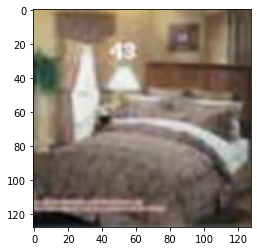

In [44]:
plt.imshow(arr.astype(np.uint8))

In [45]:
save_preds(dl, learn_gen)

In [46]:
# Train the critic

In [47]:
path_g = get_image_files( Path(path_gen))
path_i = get_image_files(Path(path_hr))
fnames = path_g + path_i

In [48]:
fnames[0]

Path('../../data/test/data0/lsun/image_gen/000038527b455eaccd15e623f2e229ecdbceba2b.jpg')

In [49]:
def get_crit_dls(fnames, bs:int, size:int):
    "Generate two `Critic` DataLoaders"
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [50]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


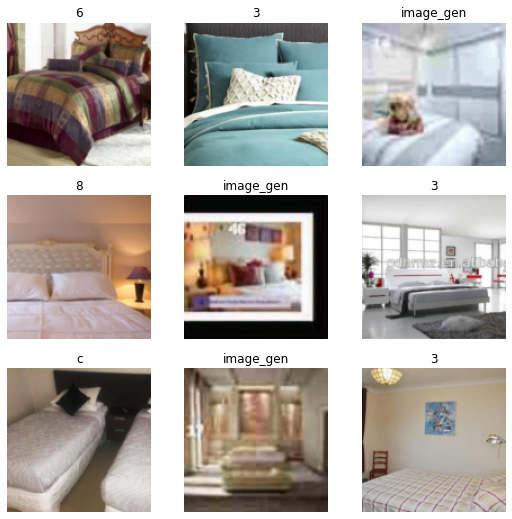

In [51]:
dls_crit.show_batch()

In [52]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [53]:
def create_crit_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [54]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [55]:
learn_crit.fit_one_cycle(1, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,-211065.531250,-218898.171875,0.037640,1:31:49


In [56]:
learn_crit.save('critic-pre2')

Path('models/critic-pre2.pth')

In [57]:
# The GAN

In [58]:
ls_crit = get_crit_dls(fnames, bs=32, size=128)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [59]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('critic-pre2')

In [60]:
learn_gen = create_gen_learner().load('gen-pre2')

In [61]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [62]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [63]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [64]:
lr = 1e-4

In [65]:
learn.fit(2, lr, wd=wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,10233.425781,0.304778,0.304778,9395.048828,1:23:13
1,10230.622070,0.304778,0.304778,10422.125977,1:18:16


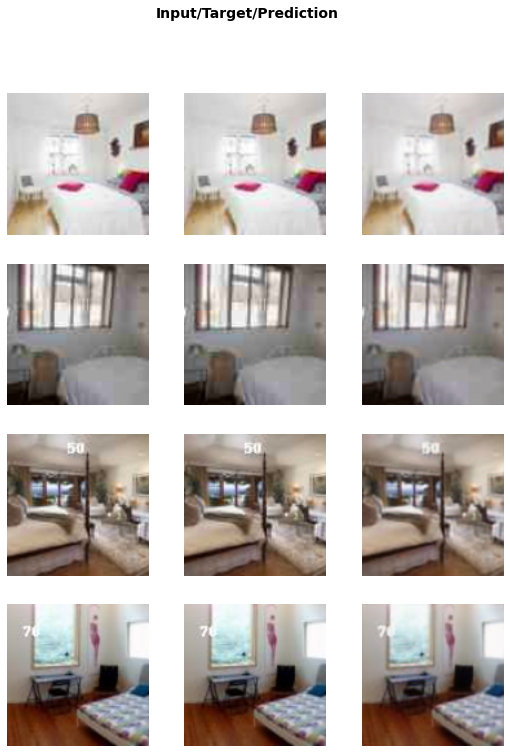

In [66]:
learn.show_results(max_n=4)